# A Neural Engineering Framework Representation of the Kalman Filter
## Introduction
The Kalman Filter is a method for estimating unknown or hidden system states using an internal model of the physical processes at work. The purpose of this project is to explore the neural implementation of the Kalman filter as defined in the course text and characterize its performance on two linear dynamic systems: a constant velocity system and a constant acceleration system. This system simply balances the known model of the system with an observation as new inputs are being received. This diagram is illustrated in the figure below from the textbook. 
![Kalman Filter](image.png)
*Figure 1 - Kalman Filter*

The purpose of this project will be to evaluate a simple Kalman filter implemented in the NEF framework against a computational Kalman filter implemented traditionally.

### Subsystems
The neurobiological implementation of a Kalman filter would begin with an input image to the eyes. In an extended version of this project, image position encoding could be conducted, however, the position is assumed to be encoded into neural activity through the eyes and decoded into position. This position will be an ensemble encoding of a 1-dimensional position as it moves at either constant acceleration or constant velocity. This position ensemble is then fed into the kalman filter iteself. From Figure 1:
- The C matrix represents the observation matrix
- $\sigma_y^2$ is the variance of the observations
- A is the known system model
- $\sigma_x^2$ is the variance of the state variables
- $\hat{x}$ is the predicted true state values
- $z^{-1}$ is an integrator

The weighting of the filter can be adjusted by changing the $\sigma$ values to more heavily favour either the representation or the observations. An extension would be to update the Kalman gain matrices dynamically using the update and predict model outlined in the textbook.

### Neural Specifications
Using nengo.Nodes as inputs to the neurobiological portion of the simulations, the observed inputs, the A and C matrices and the "pre-learned" variances of the state representation and the observations are represented and encoded into EnsembleArrays or Ensembles as appropriate. This abstraction allows the kalman filter to be appropriately represented without worrying about receiving input of updating the matrix values or weightings. Through matrix multiplication, the values of $P^{-1}$, $\frac{A*x(t)}{\sigma_x^2}$ and $\frac{C*y(t)}{\sigma_y^2}$ are generated. These values are then appropriately summed and represented to obtain the representation of $\dot{x}$. This ensemble is then integrated and fed back in the the $x(t)$ value used to determine the $\dot{x}$ value.

### Non neural Specifications
First we need to construct the physical process that we are trying to find estimates for. Modelling kinematic motion can be done through state space equation in discrete time using simple forward integration. For system dynamics in the horizontal axis of the 2D plane let $$x[n+1] = x[n] + \dot{x} * dt$$ and system dynamics in the vertical axis be $$y[n+1] = y[n] + \dot{y}[n] * dt$$ where $$\dot{y}[n+1] = \dot{y}[n] + \ddot{y} * dt$$ The State Variables that we want to estimate are going to be $x[n], \dot{x}[n], y[n], \dot{y}[n], \ddot{y}[n]$. In state space this gives us 
$$
 \begin{bmatrix}
 x[n+1] \\
 \dot{x}[n+1] \\
 y[n+1] \\
 \dot{y}[n+1] \\
 \ddot{y}[n+1]
 \end{bmatrix}
 =
 \begin{bmatrix}
 1 & dt & 0 & 0 & 0 \\
 0 & 1 & 0 & 0 & 0 \\
 0 & 0 & 1 & dt & 0 \\
 0 & 0 & 0 & 1 & dt \\
 0 & 0 & 0 & 0 & 1
 \end{bmatrix}
 \begin{bmatrix}
 x[n] \\
 \dot{x}[n] \\
 y[n] \\
 \dot{y}[n] \\
 \ddot{y}[n]
 \end{bmatrix}
$$
The noisy measurement values that we are able to observe will be $x[n]$ and $y[n]$. Using the kalman filter we will both be able to achieve some degree of tracking and estimate the true values of the rest of the states through added gaussian noise. A measure of the performance can be obtained by using the root-mean squared value against ideal performance.

### Comparisons
To evaluate the performance of the nerual kalman filter the performance vs number of neurons will be considered.
## Code
The following code implements the Kalman filter in a prediction and update model simultaniously and the error over time of the system is illustrated visually in the following plots.

In [11]:
import nengo
import numpy as np
import matplotlib.pyplot as plt
nengo.rc.set('progress', 'progress_bar', 
             'nengo.utils.progress.TerminalProgressBar')
%matplotlib inline

In [2]:
def system_dynamics(x, dt):
    A = np.array([
        [1, dt, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, dt, 0],
        [0, 0, 0, 1, dt],
        [0, 0, 0, 0, 1]
    ])
    next_state = A @ x
    return next_state

def output_from_state(x):
    C = np.array([[1, 0, 0, 0, 0], [0, 0, 1, 0, 0]])
    return C @ x

def kalman_filter_trad(x_hat, next_y, dt):
    variance_y = 1
    variance_x = (1/10)**2
    A = np.array([
        [1, dt, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, dt, 0],
        [0, 0, 0, 1, dt],
        [0, 0, 0, 0, 1]
    ])
    
    C = np.array([[1, 0, 0, 0, 0], [0, 0, 1, 0, 0]])
    
    K = np.linalg.inv((np.eye(2) + variance_x * C @ (variance_y ** -1 * C))) @ (variance_x * C.T * variance_y ** -1)
    
    next_x_hat = (np.eye(2) - K @ C) @ A @ x_hat + K @ next_y
    return next_x_hat


def kalman_filter(x_hat, next_y, dt, P):
    return kalman_filter_standard(x_hat, next_y, dt, P)
    
def kalman_filter_course(x_hat, next_y, dt):
    variance_y = 1
    variance_x = (1/10)**2
    A = np.array([
        [1, dt, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, dt, 0],
        [0, 0, 0, 1, dt],
        [0, 0, 0, 0, 1]
    ])
    C = np.array([[1, 0, 0, 0, 0], [0, 0, 1, 0, 0]])
    P = np.array((np.eye(5) / variance_x) + (np.dot(C.T, C) / variance_y))
    next_x_hat = np.linalg.inv(P) @ (((A @ x_hat) / variance_x) + ((C.T @ next_y)) / variance_y)
    return next_x_hat

def kalman_filter_standard(x_hat, next_y, dt, P):
    A = np.array([
        [1., dt, 0, 0, 0],
        [0, 1., 0, 0, 0],
        [0, 0, 1., dt, 0],
        [0, 0, 0, 1., dt],
        [0, 0, 0, 0, 1.]
    ])
    
    C = np.array([[1, 0, 0, 0, 0], [0, 0, 1, 0, 0]])
    
    x_super_minus = A @ x_hat
    P_super_minus = A @ P @ A.T
    
    K = P_super_minus @ C.T @ np.linalg.inv(C @ P_super_minus @ C.T + np.eye(2) * 1)
    new_P = (np.eye(5) - K @ C) @ P_super_minus
    return x_super_minus + K @ (next_y - C @ x_super_minus), new_P

In [3]:
t_length = 10
num_samples = 50000
t_space = np.linspace(0, t_length, num=num_samples)
dt = t_length / num_samples

# Create Random Noise
noise_mean = 0
noise_std = 1
P_prev = np.eye(5)
random_noise = np.random.normal(noise_mean, noise_std, (num_samples, 2, 1))
random_state_noise = np.random.normal(noise_mean, 0, (num_samples, 5, 1))

# Initialize state and output recorders
state_recorder = np.array([[[0], [2], [10], [0], [-9.81]] + random_state_noise[0]])
output_recorder = np.array([output_from_state(state_recorder[0]) + random_noise[0]]) 
prediction_recorder, P_prev = kalman_filter(np.array([[0, 0, 0, 0, 0]]).T, output_recorder[0], dt, P_prev) 
prediction_recorder = np.array([prediction_recorder])

# Initialize next state and next output
next_state = [system_dynamics(state_recorder[0], dt) + random_state_noise[1]]
next_output = [output_from_state(next_state[0]) + random_noise[1]]
next_estimate, P_prev = kalman_filter(prediction_recorder[0], next_output[0], dt, P_prev)
next_estimate = [next_estimate]

state_recorder = np.append(state_recorder, next_state, axis=0)
output_recorder = np.append(output_recorder, next_output, axis=0)
prediction_recorder = np.append(prediction_recorder, next_estimate, axis=0)

for _, (t, rand_n, rand_state_n) in enumerate(zip(t_space[2:], random_noise[2:, :], random_state_noise[2:, :])):
    next_state = [system_dynamics(next_state[0], dt) + rand_state_n]
    next_output = [output_from_state(next_state[0]) + rand_n]
    next_estimate, P_prev = kalman_filter(next_estimate[0], next_output[0], dt, P_prev)
    next_estimate = [next_estimate]
    
    state_recorder = np.append(state_recorder, next_state, axis=0)
    output_recorder = np.append(output_recorder, next_output, axis=0)
    prediction_recorder = np.append(prediction_recorder, next_estimate, axis=0)


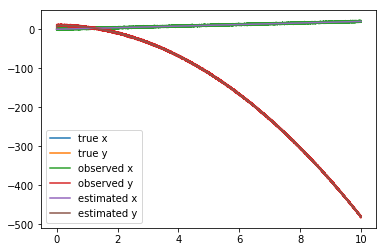

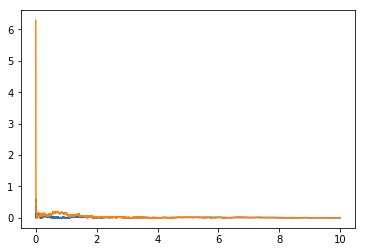

In [4]:
plt.figure()
plt.plot(t_space, np.squeeze(state_recorder[:, [0, 2]]))
plt.plot(t_space, np.squeeze(output_recorder))
plt.plot(t_space, np.squeeze(prediction_recorder[:, [0, 2]]))
plt.legend(['true x', 'true y', 'observed x', 'observed y', 'estimated x', 'estimated y'])
plt.figure()
plt.plot(t_space, np.absolute(np.squeeze(state_recorder[:, [0, 2]]) - np.squeeze(prediction_recorder[:, [0, 2]])))

## Neural Kalman filter constant velocity 1D
To begin the neural kalman filter, we will consider the 1-dimensional case with a constant velocity term. In discrete time the first order differential equation is $$x[n+1] = x[n] + \dot{x}[n]*dt$$ We take the position x as an input into an ensemble of neurons. In state space we have 
$$
\begin{bmatrix}
x[n+1] \\
\dot{x}[n+1]
\end{bmatrix}= 
\begin{bmatrix}
1 & dt \\
0 & 1
\end{bmatrix}
\begin{bmatrix}
x[n] \\
\dot{x}[n]
\end{bmatrix}
$$ In continuous time however, the system is simply $\dot{x} = const$. As input, our system will encode the position of an object moving at a constant velocity in 1-dimension and we will try to estimate the true value of the states $x$ and $\dot{x}$.

In [5]:
def kalman_simulator(slope, num_neurons, plotting):
    tau=1
    #A = np.asarray([[1, 0.01], [0, 1]]) * tau + np.random.normal(0, 0.1, (2, 2)) + np.eye(2)
    A = np.asarray([1]) + np.random.normal(0, 0.1)
    C = np.asarray([1])
    my_radius = 4
    std_noise = 0.5
    std_state = 0.1
    my_slope = slope

    my_func = lambda x:my_slope * x + np.random.normal(0, std_noise)
    model = nengo.Network(label='Kalman Filter Network')
    # output_representation--> measurement
    with model:
        # Create input position aka y
        position = nengo.Node(my_func)
        output_representation = nengo.Ensemble(num_neurons, dimensions=1, radius=my_radius)
        nengo.Connection(position, output_representation)

        input_position = nengo.Probe(position, synapse=0.01)
        probe_1 = nengo.Probe(output_representation, synapse=0.01)

        # Create C representation
        C_input = nengo.Node(C.ravel())
        C_ensemble = nengo.networks.EnsembleArray(num_neurons, C.size, radius=my_radius)
        nengo.Connection(C_input, C_ensemble.input)
        C_probe = nengo.Probe(C_ensemble.output, synapse=0.01)

        # Create C squared
        C_squared = nengo.networks.Product(num_neurons, dimensions=C.size)

        nengo.Connection(C_ensemble.output, C_squared.A)
        nengo.Connection(C_ensemble.output, C_squared.B)

        C_squared_sum = nengo.Ensemble(num_neurons, dimensions=1)
        nengo.Connection(C_squared.output[0], C_squared_sum)
        #nengo.Connection(C_squared.output[1], C_squared_sum)

        C_squared_probe = nengo.Probe(C_squared_sum, synapse=0.01)

        # Create A
        A_input = nengo.Node(A.ravel())
        A_ensemble = nengo.networks.EnsembleArray(num_neurons, A.size, radius=my_radius)
        nengo.Connection(A_input, A_ensemble.input)
        A_probe = nengo.Probe(A_ensemble.output, synapse=0.01)

        # Create simga squareds
        sigma_squared_observation = nengo.Node(lambda x:std_noise**2)
        sigma_squared_state = nengo.Node(lambda x: std_state**2)

        sigma_representation_observation_inv = nengo.Ensemble(num_neurons, dimensions=1)
        nengo.Connection(sigma_squared_observation, sigma_representation_observation_inv, function=lambda x : 1/x)


        sigma_representation_state_inv = nengo.Ensemble(num_neurons, dimensions=1)
        nengo.Connection(sigma_squared_state, sigma_representation_state_inv, function=lambda x : 1/x)

        input_to_product = nengo.Ensemble(num_neurons*4, dimensions=2, radius=my_radius)

        nengo.Connection(C_squared_sum, input_to_product[0])
        nengo.Connection(sigma_representation_observation_inv, input_to_product[1])

        prod = nengo.Ensemble(num_neurons*4, dimensions=1, radius=my_radius)
        nengo.Connection(input_to_product, prod, function=lambda x: x[0] * x[1])

        P = nengo.Ensemble(num_neurons*4, dimensions=1, radius=my_radius)
        nengo.Connection(prod, P)
        nengo.Connection(sigma_representation_state_inv, P)

        # Create P inverse
        P_inv = nengo.Ensemble(num_neurons*6, dimensions=1, radius=my_radius)
        nengo.Connection(P, P_inv, function=lambda x: 1/x)

        pinv_probe = nengo.Probe(P_inv, synapse=0.01)


        # Create y / sigma
        combined_observation_sigma = nengo.Ensemble(num_neurons, dimensions=2)
        nengo.Connection(output_representation, combined_observation_sigma[0])
        nengo.Connection(sigma_representation_observation_inv, combined_observation_sigma[1])
        product_obs_sigma = nengo.Ensemble(num_neurons, dimensions=1)
        nengo.Connection(combined_observation_sigma, product_obs_sigma, function=lambda x: x[0] * x[1])

        # Create A / sigma squared
        sigma_state_ensemble_array = nengo.networks.EnsembleArray(num_neurons, A.size, radius=1)
        nengo.Connection(sigma_representation_state_inv, sigma_state_ensemble_array.input, function=lambda x: [x])
        combined_A_sigma = nengo.networks.Product(num_neurons, dimensions=A.size)
        nengo.Connection(sigma_state_ensemble_array.output, combined_A_sigma.A)
        nengo.Connection(A_ensemble.output, combined_A_sigma.B)
        A_sigma_probe = nengo.Probe(combined_A_sigma.output, synapse=0.01)

        # Create C * y / sigma squared
        y_sigma_array = nengo.networks.EnsembleArray(num_neurons, C.size, radius=1)
        nengo.Connection(product_obs_sigma, y_sigma_array.input, function=lambda x: [x])
        combined_C_y_sigma = nengo.networks.Product(num_neurons, dimensions=C.size)
        nengo.Connection(C_ensemble.output, combined_C_y_sigma.A)
        nengo.Connection(y_sigma_array.output, combined_C_y_sigma.B)
        C_y_sigma_combined_probe = nengo.Probe(combined_C_y_sigma.output, synapse=0.01)

        # Create State Representation and A * x / sigma squared
        x_hat = nengo.networks.EnsembleArray(num_neurons*4, C.size, radius=2)

        #nengo.Connection(x_hat.output, x_hat.input, synapse=tau)
        t_1 = np.asarray([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
        t_2 = np.asarray([[1, 0], [0, 1], [1, 0], [0, 1]])
        A_x_sigma_combined = nengo.networks.Product(num_neurons*4, dimensions=1)
        nengo.Connection(combined_A_sigma.output, A_x_sigma_combined.A)
        nengo.Connection(x_hat.output, A_x_sigma_combined.B)
        summing_array_A_x_simga = nengo.networks.EnsembleArray(num_neurons, n_ensembles=1, radius=2)
        nengo.Connection(A_x_sigma_combined.output, summing_array_A_x_simga.input)
        combined_A_x_sigma_probe = nengo.Probe(summing_array_A_x_simga.output, synapse=0.01)

        # Setup recurrant network
        inner_sum = nengo.networks.EnsembleArray(num_neurons*4, C.size, radius=my_radius)
        nengo.Connection(summing_array_A_x_simga.output, inner_sum.input)
        nengo.Connection(combined_C_y_sigma.output, inner_sum.input)

        p_inv_ens_arr = nengo.networks.EnsembleArray(num_neurons*4, C.size, radius=2)
        nengo.Connection(P_inv, p_inv_ens_arr.input, function=lambda x: [x])

        final_product = nengo.networks.Product(num_neurons * 4, dimensions=1)
        nengo.Connection(p_inv_ens_arr.output, final_product.A)
        nengo.Connection(inner_sum.output, final_product.B)
        # nengo.Connection(final_product.output, x_hat.input)
        x_hat_probe = nengo.Probe(x_hat.output, synapse=0.01)

        integrator = nengo.networks.Integrator(tau, num_neurons, dimensions=1)
        nengo.Connection(final_product.output, integrator.input)
        nengo.Connection(integrator.output, x_hat.input)

        x_probe = nengo.Probe(integrator.output, synapse = 0.01)



    with nengo.Simulator(model) as sim:
        sim.run(3)
    plt.figure()
    plt.title("Step input")
    plt.xlabel("Time (s)")
    plt.plot(sim.trange(), sim.data[probe_1])
    plt.plot(sim.trange(), [my_slope * x for x in sim.trange()])
    plt.plot(sim.trange(), sim.data[x_hat_probe])
    plt.title("Kalman Filter")
    plt.xlabel("Time (s)")
    plt.legend(['Noisy Observation', 'True position', 'State Estimate Position'])
    if plotting:
        plt.figure()
        plt.title('C Array')
        plt.plot(sim.trange(), sim.data[C_probe])
        plt.figure()
        plt.title('A Array')
        plt.plot(sim.trange(), sim.data[A_probe])
        plt.figure()
        plt.title('P Inverse')
        plt.plot(sim.trange(), sim.data[pinv_probe])
        plt.figure()
        plt.title('C squared')
        plt.plot(sim.trange(), sim.data[C_squared_probe])
        plt.figure()
        plt.title('Error')
        plt.plot(sim.trange(), np.squeeze(sim.data[x_hat_probe].T - np.array([my_slope * x for x in sim.trange()])))
    rmse = np.sqrt(np.average((sim.data[x_hat_probe].T - np.array([my_slope * x for x in sim.trange()]))**2))
    print(f'RMSE: {rmse}')
    return rmse

E:\anaconda\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide
E:\anaconda\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide
E:\anaconda\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in true_divide


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

RMSE: 0.1802819812360895


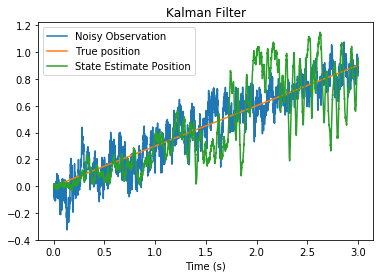

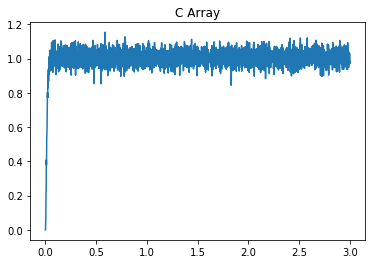

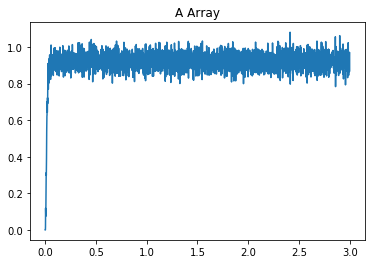

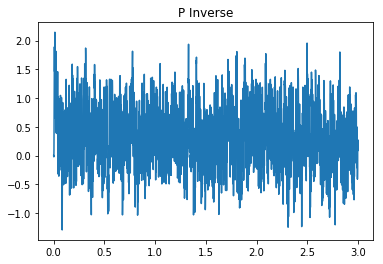

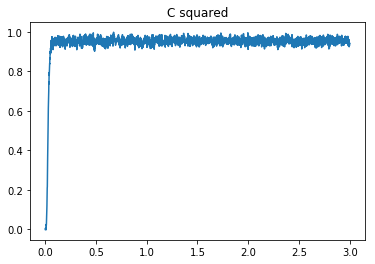

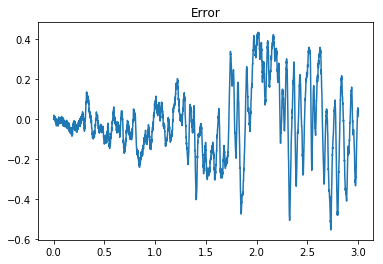

In [6]:
my_slope = 0.3
kalman_simulator(my_slope, 200, True)

plt.show()

E:\anaconda\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide
E:\anaconda\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide
E:\anaconda\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in true_divide


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

RMSE: 0.45822402565514486


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

RMSE: 0.518827071609417


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

RMSE: 0.368145389966621


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

RMSE: 0.46554993071695244


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

RMSE: 0.3654648357649085


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

RMSE: 0.1338346643626072


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

RMSE: 0.1616966829774149


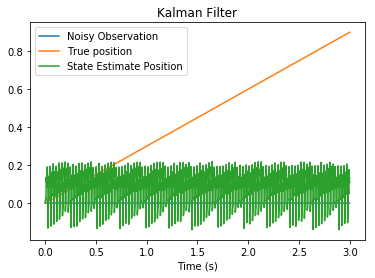

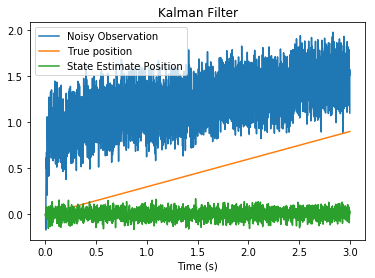

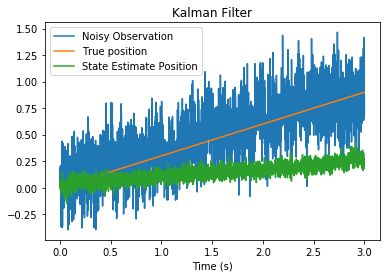

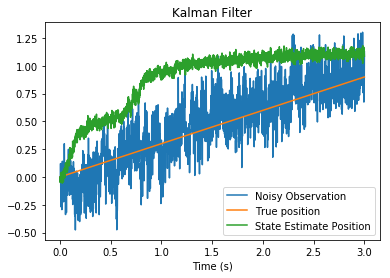

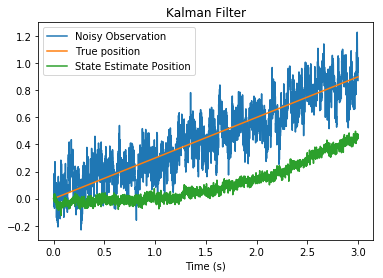

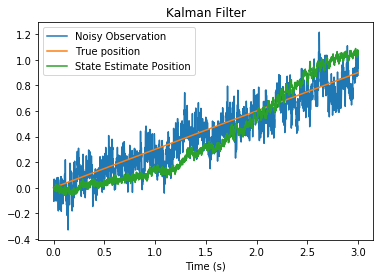

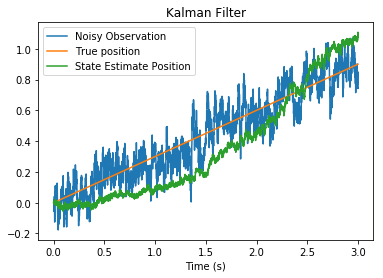

In [7]:
my_slope = 0.3
rmses = []
for i in [2, 8, 16, 32, 64, 128, 256]:
    RMSE = kalman_simulator(my_slope, i, False)
    rmses.append(RMSE)

E:\anaconda\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide
E:\anaconda\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide
E:\anaconda\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in true_divide


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

RMSE: 0.13197602070162895


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

RMSE: 0.27332909311345904


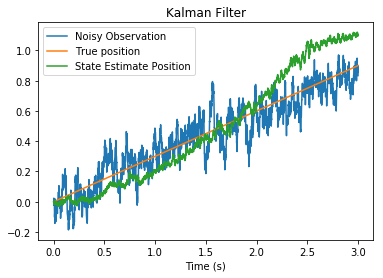

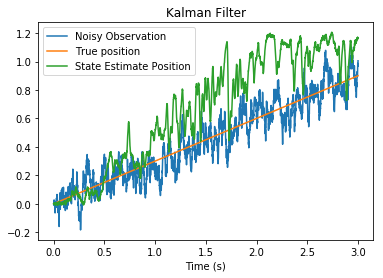

In [8]:
my_slope = 0.3
for i in [512, 1024]:
    RMSE = kalman_simulator(my_slope, i, False)
    rmses.append(RMSE)

Text(0.5, 1.0, 'RMSE vs Number of neurons')

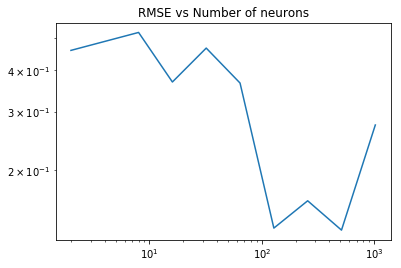

In [9]:
plt.figure()
plt.loglog([2, 8, 16, 32, 64, 128, 256, 512, 1024], rmses)
plt.title('RMSE vs Number of neurons')

## Discussion
Using neural representations, matrix multiplication, neural dynamics and transformations, the creation of a neural kalman filter was attempted but results were unsatisfactory for the constant velocity case. Difficulties arose generating the Kalman filter equations, as, compared to the equations in the book. To simplify, only the one dimensional constant velocity case was considered. One large source of error is presumably the computation of the $P^{-1}$ value which is significantly more noisy than other ensembles due to the number of inversions required. Plotting the rmse values shows a decline into an increase of error as the simulation increases the number of neurons in use, indicating that there is some error in the simulation.

## Conclusion
The issues with implementing the Kalman filter using the Neural Engineering Framework include 
- Difficulties with dimensionality
- Issues with multiplication and inverse math
- Integration accuracy

These can be addressed by first verifying the accuracy of the code in this report. Ideally, the kalman filter as traditionally used and discussed in the introduction would be able to be introduced and simulated despite limitations due to high dimensionality. 